<!--HEADER-->
*Notas de aula de Modelagem Matemática - 2020/2 [- Ricardo M. S. Rosa (IM/UFRJ)](http://www.im.ufrj.br/rrosa)*

<!--BADGES-->
<a href="https://nbviewer.jupyter.org/github/rmsrosa/modelagem_matematica/blob/modmat2020p2/notas_de_aula/25.00-EDP_onda.ipynb" target="_blank"><img align="left" src="https://img.shields.io/badge/view%20in-nbviewer-orange" alt="View in NBViewer" title="View in NBViewer"></a><a href="https://mybinder.org/v2/gh/rmsrosa/modelagem_matematica/julia-env-for-binder?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Frmsrosa%252Fmodelagem_matematica%26branch%3Dmodmat2020p2%26urlpath%3Dtree%252Fmodelagem_matematica%252Fnotas_de_aula/25.00-EDP_onda.ipynb" target="_blank"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open in binder"></a><a href="https://nbviewer.jupyter.org/github/rmsrosa/modelagem_matematica/blob/modmat2020p2/notas_de_aula/slides/25.00-EDP_onda.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/view-slides-darkgreen" alt="View Slides" title="View Slides"></a>&nbsp;

<!--NAVIGATOR-->
[<- 24. Equação do calor unidimensional](24.00-EDP_calor.ipynb) | [Página inicial](00.00-Pagina_inicial.ipynb) | [26. Equação do calor em duas dimensões espaciais ->](26.00-EDP_calor_bidimensional.ipynb)

---


# Equação da onda unidimensional

* Vamos considerar a equação da onda
$$ u_{tt} = c^2 u_{xx}.
$$

In [1]:
using DifferentialEquations
using Plots

## Solução analítica

* A equação da onda pode ser vista como a superposição de duas ondas viajando com a mesma velocidade mas em sentidos opostos:
$$ u(t,x) = F(x-ct) + G(x+ct).
$$

* De fato, temos
$$ u_t = (-c)F'(x-ct) + cG'(x+ct), \qquad u_{tt} = c^2(F''(x-ct) + G''(x+ct))
$$

* Por outro lado, 
$$ u_x = F'(x-ct) + G'(x+ct), \qquad u_{xx} = F''(x-ct) + G''(x+ct).
$$

* Logo, desde que $F$ e $G$ sejam duas vezes diferenciáveis, temos $u(t,x)$ também duas vezes diferenciáveis e satisfazendo a equação da onda.

* As formas de $F$ e $G$ dependem das condições iniciais $u(0,x) = u_0(x)$ e $u_t = v_0(x)$:
$$ F(x) + G(x) = u_0(x), \quad -cF'(x) + cG'(x) = v_0(x).
$$

### Transformação para um sistema de equações de primeira ordem

* Assim como em EDOs de segunda ordem, consideramos o sistema
$$ \begin{cases}
    u_t = v, \\
    v_t = c^2u_{xx}.
  \end{cases}
$$

* Podemos representar o novo conjunto de incógnigas $u$ e $v$ em forma vetorial:
$$ U = \left(\begin{matrix} u \\ v \end{matrix}\right)
$$

* E a equação de segunda ordem em $t$ se transforma em uma equação de primeira ordem em $t$ para $U$:
$$ U_t = AU
$$

* Onde, em forma de bloco,
$$ A = \left[ \begin{matrix} 0 & I \\ c^2\partial_{x}^2 & 0 \end{matrix} \right]
$$

* Mais explicitamente,
$$ \frac{\partial}{\partial t} \left(\begin{matrix} u \\ v \end{matrix}\right) = \left[ \begin{matrix} 0 & I \\ c^2\partial_{x}^2 & 0 \end{matrix} \right] \left(\begin{matrix} u \\ v \end{matrix}\right)
$$



## Simulação numérica

* Vamos considerar condições de contorno de Dirichlet homogêneas, $u(t,0)=u(t,L) = 0$.

* Isso representa a situação em que os extremos da corda estão fixos na mesma altura.

* Nesse caso, definimos a discretização do Laplaciano como no caso da equação do calor.

In [2]:
function δ²(u, h2, ::Val{:dir})
    ddu = zero(u)
    for j = 2:length(u)-1
        ddu[j] = (u[j+1] - 2u[j] + u[j-1])/h2
    end
    return ddu
end

δ² (generic function with 1 method)

### Representação numérica do sistema

* O vetor $U=(u,v)$, que na verdade é uma dupla de funções, pode ser representado, com a discretização, na forma de uma matriz de duas colunas
$$ U = [u \;\; v] = \left[\begin{matrix} u_1 & v_1 \\ \vdots & \vdots \\ u_N & v_N \end{matrix}\right]
$$

* Com a notação do Julia, extraímos $u$ e $v$ de $U$ com
$$ u = U[:,1], \quad v = U[:,2]
$$

### Lei de evolução

* Com essa representação, podemos definir a lei de evolução do sistema discretizado da seguinte forma.

In [3]:
function dUdt_onda!(dUdt, U, p, t)
    c2, h2 = p
    u = U[:,1]
    v = U[:,2]
    dUdt[:,1] .= v
    dUdt[:,2] .= c2 * δ²(u, h2, Val(:dir))
    return nothing
end

dUdt_onda! (generic function with 1 method)

### Definindo parâmetros e resolvendo o sistema

In [4]:
c = 0.5 # 
L = 2π # comprimento do intervalo [0,L]
N = 80 # número de pontos da malha
h = L/(N-1) # comprimento de cada partição na malha
x = range(0.0, L, length=N) # discretização do intervalo [0,L] com N pontos, incluindo os extremos
u₀ = exp.(-(x.-L/2).^2) .- exp(-L^2/4) # condição inicial
v₀ = -2*(x.-L/2) .* exp.(-(x.-L/2).^2) # condição inicial w₀ = ∂ₓv₀
U₀ = [u₀ v₀]
p = [c^2, h^2] # parâmetros
Tf = 2*L/c # tempo final
τ = 0.1 # intervalos de tempo
tspan = (0.0,Tf) # intervalo de tempo
prob = ODEProblem(dUdt_onda!, U₀, tspan, p, saveat = τ)
nothing

In [5]:
sol = solve(prob, Tsit5())
sol.retcode

:Success

┌ Info: Saved animation to 
│   fn = /Users/rrosa/Documents/git_repositories/modelagem_matematica/notas_de_aula/img/anim_onda1D_a.gif
└ @ Plots /Users/rrosa/.julia/packages/Plots/SVksJ/src/animation.jl:104


Plots.AnimatedGif("/Users/rrosa/Documents/git_repositories/modelagem_matematica/notas_de_aula/img/anim_onda1D_a.gif")
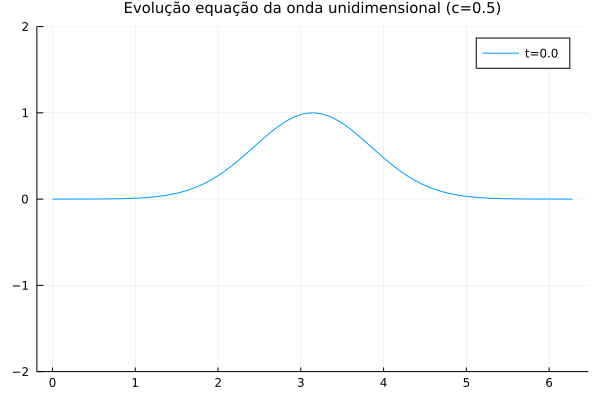

In [6]:
anim = @animate for (t,U) in zip(sol.t, sol.u)
    plot(x, U[:,1], ylims=(-2.0, 2.0), label="t=$(round(t,digits=2))",
        title="Evolução equação da onda unidimensional (c=$c)", titlefont=10)
end
gif(anim, joinpath("img", "anim_onda1D_a.gif"), fps = 20)

<!--NAVIGATOR-->

---
[<- 24. Equação do calor unidimensional](24.00-EDP_calor.ipynb) | [Página inicial](00.00-Pagina_inicial.ipynb) | [26. Equação do calor em duas dimensões espaciais ->](26.00-EDP_calor_bidimensional.ipynb)